# Title

## Table of contents

1. [Introduction](#Introduction)
2. [Data preprocessing](#Data-preprocessing)
3. [Imports](#Imports) 
    1. [Libraries](#Libraries)
    2. [Dataset](#Dataset)
    3. [Dictionaries](#Dictionaries)
4. [Data exploration](#Data-exploration)
    1. [Number of quotations by gender from 2015 to 2020](#Number-of-quotations-by-gender-from-2015-to-2020)
    2. [Number of occurrences by gender from 2015 to 2020](#Number-of-occurrences-by-gender-from-2015-to-2020)
    3. [Number of speakers by gender from 2015 to 2020](#Number-of-speakers-by-gender-from-2015-to-2020)
    4. [Lexical fields](#Lexical-fields)
    5. [Age of the speakers](#Age-of-the-speakers)
    6. [#MeToo breatdh in the news](##MeToo-breadth-in-the-news)
5. [Observational study](#Observational-study)
    1. [Data preparation](#Data-preparation)
    2. [Create a balanced dataset](#Create-a-balanced-dataset)
        1. [Pair identical speakers](#Pair-identical-speakers)
        2. [Pair non-identical speakers](#Pair-non-identical-speakers)
            1. [Propensity score calculation](#Propensity-score-calculation)
            2. [Matching by gender](#Matching-by-gender)
            3. [Matching by category of occupation](#Matching-by-category-of-occupation)
    3. [Results](#Results)
        1. [Comparison between men and women speakers in general](#Comparison-between-men-and-women-speakers-in-general)
        2. [A first look at the occupations...](#A-first-look-at-the-occupations...)
        3. [Comparison between men and women speakers by category of occupation](#Comparison-between-men-and-women-speakers-by-category-of-occupation)

## Introduction
In this project, we will use the [Quotebank dataset](#https://dl.acm.org/doi/pdf/10.1145/3437963.3441760), an open corpus of 178 million quotations attributed to the speakers who uttered them, extracted from 162 million English news articles published between 2008 and 2020. We will here restrict our analysis to articles published between 2015 and 2020.

## Data preprocessing
We are provided with one dataset per year, which are pretty large (from 792,3Mo to 4,84Go). The datasets provided to us follow the pattern below: 

```
root
 |-- quoteID: string 
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- date: string 
 |-- numOccurrences: int
 |-- probas: list
 |-- urls: list
 |-- phase: string 
```

1. Since our analysis will be based on the difference between male and female speakers, we need to keep only the quotations for which the speakers are known. We therefore dropped the quotations for which the speaker is unknown, and made the choice to keep only the quotations for which the probability that it is the correct speaker is greater than 0.7.


2. To further reduce the datasets, we removed columns of no interest to our analysis: urls, probas, phase and quoteID. We splitted the dataset of 2017 in two: January-October (date of the emergence of the movement) and October-December. After that, we removed the date, still only knowing the year of the dataset will be enough for our analysis. Steps 1 and 2 were performed using Google colab. 
The code for these two first steps is available [here](src/Reduce_data.ipynb).


3. Next, in order to have useful information about the speakers, we used additional speaker metadata available for ~9M unique Wikidata entities (identified by their QID) in the form of a .parquet file named speaker_attributes.parquet. We removed from the original datasets all the quotations for which multiple QIDS are linked: indeed, we cannot now which of the homonyms is the real speaker. Then we merged our dataset with the attributes of the speakers (thanks to their `qids`), and we decided to keep the following attributes: `gender`, `date_of_birth`, `occupation` and `academic_degree`. We did not kept `ethnic_group` neither `religion` since they are very rarely known. For each dataset, we computed the age of the speaker the year of the quotation, and thus transformed the column `date_of_birth` by a column `age`. 


4. Then, we dropped all quotations for which one of its attribute is not known, since we will need all of them for our analyses. We also replaced all the wikicodes in the dataset with readable information, using a [dictionnary](data/wikidata_labels_descriptions_quotebank.csv.bz2) linking wikidata labels and descriptions. The datasets are now reduced, and they are stored under .json.bz2 files and are named "observational-{year}". These files will be used for the [data exploration](#Data-exploration), and they follow the following pattern:
```
root
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- numOccurrences: int
 |-- gender: ndarray
 |-- age: int
 |-- occupation: ndarray
 |-- academic_degree: ndarray
```


5. In order to conduct the observational study, we created one single dataframe with all the quotes of all years. We added a column `year` to be able to still access the year of the quotation, and also a column `label`: if 0, the quotation has been said before the #MeToo movement, if 1, the quotation has been said after the #MeToo movement. This is the dataframe we will use for the [observational study](#Observational-study), and is stored under "'data_observational.json.bz2". 

The final dataset contains 1,761,820 entries and is following pattern:
```
root
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- numOccurrences: int
 |-- gender: ndarray
 |-- age: int
 |-- occupation: ndarray
 |-- academic_degree: ndarray
 |-- label: int 0 or 1
 |-- year: int
```

The code for step 3, 4 and 5 is available [here](src/Create_data_obs_study.ipynb).

## Imports

### Libraries

In [1]:
#pandas/numpy
import pandas as pd
import numpy as np

#loading data
import bz2
import json

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import wordcloud
from PIL import Image
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go

#math operations
import math

#statistics
from scipy import stats
#from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin

#matching algorithm
import networkx as nx

#util functions 
from utils import gmean_occupations, visualize_by_occupation, quotes_by_gender, unique_speaker_per_gender, get_champlex

#count in collection
from collections import Counter

#warnings
import warnings
#ignore future warnings
#warnings.filterwarnings('ignore')

### Dataset


In [2]:
DATA_FOLDER = 'data/'
QUOTES_DATA = DATA_FOLDER + 'data_observational.json.bz2'

In [3]:
quotes = pd.read_json(QUOTES_DATA)

### Dictionnaries

Since our project aims to focus on the representation of female speakers in the news depending on their profile, we needed to classify occupations into more global categories. Thus, we classified manually for all

In [4]:
DICTIONNARY_FOLDER = DATA_FOLDER + 'dictionnaries/'
DICT_OCCUPATIONS = DICTIONNARY_FOLDER + 'occupations_categories.json'
DICT_DEGREES = DICTIONNARY_FOLDER + 'degrees_categories.json'

In [5]:
with open(DICT_OCCUPATIONS) as f:
    dict_occupations = json.load(f)

In [6]:
with open(DICT_DEGREES) as f:
    dict_degrees = json.load(f)

## Data exploration

### Number of quotations by gender from 2015 to 2020

### Number of occurrences by gender from 2015 to 2020

### Number of speakers by gender from 2015 to 2020

### Lexical fields

### Age of the speakers

### #MeToo breatdh in the news

## Observational study

### Data preparation

In this section, we prepare the dataset to analyze it. First, we will map every occupation to a more general category. We will do the same for the academic degree. 

In [7]:
print('The categories for occupations are:', list(set(dict_occupations.values())))
print('\n')
print('The categories for academic degree are:', list(set(dict_degrees.values())))


The categories for occupations are: ['Military & Order', 'Artist', 'Informatics', 'Medical', 'Administrative', 'Government', 'Teaching & Education', 'Other', 'Finance', 'Music Industry', 'Literature', 'Philosophy', 'Historian', 'Business', 'Psychology', 'Social Sciences & Ethnology', 'Media & Journalism', 'Entertainment', 'Law', 'Athlete', 'Handicraft & Agriculture', 'Activist', 'Engineer', 'Managing', 'Service', 'Scholar', 'Religion', 'Scientist']


The categories for academic degree are: ['master', 'non specified degree', 'aggregation', 'doctor', 'professor', 'candidate', 'certificate', 'not classified', 'bachelor', 'high school diploma']


In [8]:
def translate(my_list, my_dict):
    """Allows to transform a list of items into a list of corresponding categories. 
    The list returned contains uniques category (the duplicates are removed).
    
    Parameters
    ----------
    my_list: the list to be translated
    my_dict: the dictionnary according which we want to translate the list
    
    Returns
    --------
    list of uniques categories"""
    translated_list = []
    for i in my_list:
        if i in my_dict.keys():
            translated_list.append(my_dict[i])
        else:
            translated_list.append('Others')
    #Drop duplicates
    return (list(set(translated_list)))
    
        

Now, we replace the occupations and academic degrees by more general categories

In [9]:
quotes['occupation'] = quotes['occupation'].apply(lambda x: translate(x, dict_occupations))

In [10]:
quotes['academic_degree'] = quotes['academic_degree'].apply(lambda x: translate(x, dict_degrees))

For the further analyses, we distinguish two groups: 
- the speakers before #MeToo
- the speakers after #MeToo

The goal is to compare these two groups of speakers in terms of their number of quotes, and their number of occurrences. To do that, we need to group the quotations by speaker and by label: indeed, if the same speaker appear before and after #MeToo, he will be counted in the group **before** with only the quotations he said before, and he will also be counted in the group **after** with only the quotations he said after.

In [11]:
grouped_speakers = quotes.groupby(['qids', 'label'])

After having grouped the quotations per speaker, we take the attributes corresponding to the first quotation: these attributes are immutable (the `academic degree`, the `occupation`, the `speaker` name and the `gender`), thus we can recover it from the first quotation.

In [12]:
attributes_immutable = grouped_speakers.first().reset_index().drop(['year', 
                                                                   'quotation', 'numOccurrences', 'age'], axis = 1)

Now we will calculate the number of quotes per speaker, as well as the number of occurrences per speaker. We also put the age of the speaker to the median age of all its quotations. 

In [13]:
#Get the number of unique quotes per speaker
quotations_per_speaker = grouped_speakers['quotation'].count().reset_index(name='nb_quotes')

#Get the number of total occurrences of the speaker
occurrences_per_speaker = grouped_speakers['numOccurrences'].sum().reset_index(name='nb_occurrences')

#Get the median age of the speaker if she talks many times
age_per_speaker = grouped_speakers['age'].median().reset_index(name='age')

In [14]:
attributes_mutable = pd.merge(pd.merge(quotations_per_speaker, occurrences_per_speaker, on = ['qids', 'label']), 
                              age_per_speaker, on = ['qids', 'label'])

In [15]:
data_per_speaker = pd.merge(attributes_immutable, attributes_mutable, on = ['qids', 'label'])
data_per_speaker.sample(4)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age
5815,Q4161607,0,David Dilks,male,[Scientist],[doctor],1,1,77.0
303,Q1117050,0,Alfred Weidinger,male,[Historian],[doctor],1,1,55.0
1525,Q157250,0,Harold Kroto,male,"[Scientist, Teaching & Education]",[doctor],39,544,76.0
7100,Q5218322,1,Daniel Och,male,[Finance],[bachelor],6,7,56.5


Our data are almost ready for the observational study. We will one-hot encode the categorical variables `occupation`,`academic_degree` and `gender`. This will be useful later for the logistic regression.

In [16]:
dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)
dummies_gender = pd.get_dummies(data_per_speaker['gender'])

/var/folders/n_/84v0r2b53yx61w33v8clz5500000gp/T/ipykernel_2274/3217713273.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
/var/folders/n_/84v0r2b53yx61w33v8clz5500000gp/T/ipykernel_2274/3217713273.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)


In [17]:
#Drop the columns 'Others'
dummies_occ.drop(['Others'], axis = 1, inplace = True)
dummies_degree.drop(['Others'], axis = 1, inplace = True)

In [18]:
#Rename columns with more readable names
dummies_occ.columns = dummies_occ.columns.str.replace(" ", "_")
dummies_occ.columns = dummies_occ.columns.str.replace("&", "and")
dummies_degree.columns = dummies_degree.columns.str.replace(" ", "_")

Finally, we obtain a dataframe with unique combinaison (`qids`, `label`), and the attributes related to speakers during the given period (before or after #Metoo), with the categorical one being one hot encoded.

In [19]:
data_features = pd.merge(pd.merge(data_per_speaker, dummies_occ, left_index = True, right_index = True), dummies_degree, left_index = True, right_index = True)
data_features = pd.merge(data_features, dummies_gender, left_index = True, right_index = True)
data_features.sample(5)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male
733,Q1280872,1,Patrick Sensburg,male,"[Teaching & Education, Law, Government]",[doctor],33,534,47.0,0,...,0,0,1,0,0,0,0,0,0,1
1308,Q15200380,0,Franz Oswald,male,"[Engineer, Teaching & Education]",[doctor],4,4,77.0,0,...,0,0,1,0,0,0,0,0,0,1
5919,Q4227535,1,Paul Cockshott,male,"[Social Sciences & Ethnology, Teaching & Educa...",[doctor],1,1,67.0,0,...,0,0,1,0,0,0,0,0,0,1
2718,Q19310120,0,Torsten Schäfer,male,"[Teaching & Education, Media & Journalism]",[doctor],1,1,40.0,0,...,0,0,1,0,0,0,0,0,0,1
4050,Q2627391,0,Yulia Latynina,female,"[Entertainment, Media & Journalism, Literature]",[candidate],32,167,51.0,0,...,1,0,0,0,0,0,0,0,1,0


Before calculating the propensity scores, we should standardize the continuous features. Let's look at their distributions in order to choose an appropriate standardization. 

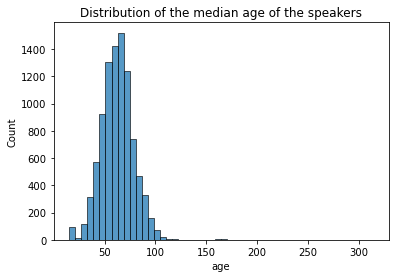

In [20]:
ax = sns.histplot(data_features['age'], bins = 50)
ax.set_title("Distribution of the median age of the speakers");

The distribution of the age seems to follow a gaussian distribution, thus, we will standardize it. If we observe people with a big age, it is certainly because we sometimes quote people who lived a long time ago. We decided to keep them, since it still reveal if we quote more men or women.

In [21]:
data_features['age'] = (data_features['age'] - data_features['age'].mean())/data_features['age'].std()
data_features.head(2)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male
0,Q1000727,0,Ruslan Galitsky,male,[Military & Order],[candidate],1,2,-1.109912,0,...,1,0,0,0,0,0,0,0,0,1
1,Q100230,0,Ludger Kühnhardt,male,[Teaching & Education],[doctor],1,1,-0.198774,0,...,0,0,1,0,0,0,0,0,0,1


Now the dataset is ready!

### Create a balanced dataset

Now the dataset is ready for the observational study: pair identical people, propensity scores calculation and matching (petit rappel de la théorie ici!)

First, we know that some speakers might appear before and after the #MeToo movement. We decide to pair them up, because the goal is to match 2 identical person in terms of their observal covariates, but here, we already know that they are the same person! With just a few years more. But we assume that the difference in age in minor compared to the fact that all other covariates are exaclty the same, and not only the observable ones, since it is the same person!
Thus, we first pair the identical speakers that appear in both groups (control and treated). Then, for the others (i.e, the speakers who speak ONLY before the movement or ONLY after), we will use the method of propensity scores calculation based on the observable covariates = `age`, `occupation`, `academic_degree`.

#### Pair up identical speakers

In [22]:
print("Number of speakers speaking both before and after",
      data_features[data_features['qids'].duplicated(keep = 'first') == True].shape[0])

Number of speakers speaking both before and after 3363


In [23]:
data_features.drop(['academic_degree', 'occupation'], axis = 1, inplace = True)

In [24]:
speakers_twice = data_features[data_features['qids'].duplicated(keep = False) == True]

#### Pair up non-identical speakers

In [25]:
speakers_once = pd.concat([data_features,speakers_twice])

In [26]:
speakers_once.drop_duplicates(keep = False, inplace = True)

In [27]:
print('Now, we will try to pair up the other speakers, they are:', speakers_once.shape[0])

Now, we will try to pair up the other speakers, they are: 2622


##### Propensity score calculation

In [28]:
occupations_for_regression = ['C('+ str(x)+ ')' for x in dummies_occ.columns.tolist()]

In [29]:
degrees_for_regression = ['C('+ str(x)+ ')' for x in dummies_degree.columns.tolist()]

In [30]:
def create_formula_from_list_categories(my_list):
    list_for_regression = ['C('+ str(x)+ ')' for x in my_list]
    formula = ''
    for i in list_for_regression:
        formula += i
        if i != list_for_regression[-1]:
            formula += ' + '
    return formula
    

In [31]:
formula_occupations = create_formula_from_list_categories(dummies_occ.columns.tolist())

In [32]:
formula_degrees = create_formula_from_list_categories(dummies_degree.columns.tolist())

In [33]:
##TODO : explain the goal of overfitting: why we set the regularization term to 0, 
#as well as why we increase the maxiter term

In [34]:
mod = smf.logit(formula='label ~  age + ' + formula_occupations + ' + ' + formula_degrees + '+ C(female)', 
                data=speakers_once)

#Without regularization term 
res = mod.fit_regularized(maxiter = 10000000000000000, alpha = 0)

# Extract the estimated propensity scores
speakers_once['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6821128477363692
            Iterations: 245
            Function evaluations: 246
            Gradient evaluations: 245
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 2622
Model:                          Logit   Df Residuals:                     2581
Method:                           MLE   Df Model:                           40
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                 0.01480
Time:                        10:53:30   Log-Likelihood:                -1788.5
converged:                       True   LL-Null:                       -1815.4
Covariance Type:            nonrobust   LLR p-value:                   0.07196
                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

In [35]:
speakers_once

,qids,label,speaker,gender,nb_quotes,nb_occurrences,age,Activist,Administrative,Artist,...,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male,Propensity_score
0,Q1000727,0,Ruslan Galitsky,male,1,2,-1.109912,0,0,0,...,0,0,0,0,0,0,0,0,1,0.360459
1,Q100230,0,Ludger Kühnhardt,male,1,1,-0.198774,0,0,0,...,0,1,0,0,0,0,0,0,1,0.485618
2,Q100308,1,Joachim Weimann,male,1,1,0.044196,0,0,0,...,0,1,0,0,0,0,0,0,1,0.459340
3,Q1006191,1,F. Földényi,male,1,1,0.287166,0,0,1,...,0,0,0,0,0,0,0,0,1,0.545214
6,Q100836,0,Gerald Hüther,male,1,1,0.104938,0,0,0,...,0,1,0,0,0,0,0,0,1,0.463997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9337,Q995192,1,Howard Wolpe,male,1,1,0.955333,0,0,0,...,0,1,0,0,0,0,0,0,1,0.509442
9340,Q99590,1,Rebekka Habermas,female,1,1,-0.259517,0,0,0,...,0,1,0,0,0,0,0,1,0,0.528434
9341,Q99634,0,Joachim Milberg,male,1,2,0.590878,0,0,0,...,0,1,0,0,0,0,0,0,1,0.448928
9344,Q99818,0,Holger Afflerbach,male,8,13,-0.320259,0,0,0,...,0,1,0,0,0,0,0,0,1,0.505353


##### Matching by gender

In [36]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [37]:
speakers_once.head(2)

,qids,label,speaker,gender,nb_quotes,nb_occurrences,age,Activist,Administrative,Artist,...,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male,Propensity_score
0,Q1000727,0,Ruslan Galitsky,male,1,2,-1.109912,0,0,0,...,0,0,0,0,0,0,0,0,1,0.360459
1,Q100230,0,Ludger Kühnhardt,male,1,1,-0.198774,0,0,0,...,0,1,0,0,0,0,0,0,1,0.485618


In [38]:
"""# Separate the treatment and control groups
treatment_df = speakers_once[speakers_once['label'] == 1]
control_df = speakers_once[speakers_once['label'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        # Adds an edge only if the individuals have the same gender
        if (control_row['gender'] == treatment_row['gender']):
            similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)""";

In [39]:
"""matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_speakers_once = speakers_once.loc[matched]
balanced_speakers = pd.concat([balanced_speakers_once, speakers_twice])""";

In [40]:
"""##Pour éviter de run again le matching 
balanced_speakers.to_json(DATA_FOLDER + 'results/balanced_dataset_gender.json.bz2')""";

In [41]:
"""#On sauvegarde aussi les valeurs de paires
textfile = open("matching_by_gender.txt", "w")
for element in matching:
    textfile.write(str(element) + "\n")
textfile.close()""";

We have saved the results of the matching in a separate file, which is called balanced_dataset_by_gender.json.bz2. The file is available [here](data/results/balanced_dataset_by_gender.json.bz2). 

##### Matching by category of occupation

Now, we will try to analyze if some categories of occupations are more represented after the movement than before among women. Here again, we will compare with the evolution of men's speech. To do that, we will focus on the 8 main represented categories in the entire dataset.

In [42]:
main_categories = data_features[dummies_occ.columns.tolist()].sum().sort_values(ascending = False).head(8)
print('The 8 categories of occupations most represented in the dataset are:', main_categories.index.to_list())

The 8 categories of occupations most represented in the dataset are: ['Teaching_and_Education', 'Government', 'Scientist', 'Social_Sciences_and_Ethnology', 'Literature', 'Historian', 'Law', 'Media_and_Journalism']


Such as in the previous section, we will match pairs of speakers according to their proprensity scores calculated above. We match exactly one speaker from the control group (speaker before #MeToo) with one speaker from the treated group (after #MeToo). We repeat the matching for each category, since we match only speakers of same gender and of same value for the category we want to analyze, i.e for example if we analyze the evolution of scientists' speech, we will pairs scientist women together, non-scientists women together, men scientists together and men non-scientists together.  

In [43]:
def match_by_category(df, category):
    # Separate the treatment and control groups
    treatment_df = df[df['label'] == 1]
    control_df = df[df['label'] == 0]

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            # Adds an edge only if the individuals have the same gender
            if (control_row['gender'] == treatment_row['gender'])  and (control_row[category] == 
                                                                        treatment_row[category]):
                similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    
    balanced_df = df.loc[matched,:]
    balanced_df.to_json(DATA_FOLDER + f'results/balanced_{category}.json.bz2')

In [44]:
#Cellule a decommenter le jour du rendu 
"""for category in main_categories.index:
    match_by_category(speakers_once, category)""";

We have saved the results of the matching in separate .json.bz2 files. They are available [here](data/results/balanced_{occupation}.json.bz2). 

## Results

### Comparison between men and women speakers in general

In [45]:
DATA_FOLDER_RESULT = 'data/results/'
BALANCED_DATA_BY_GENDER = DATA_FOLDER_RESULT + 'balanced_dataset_by_gender.json.bz2'

In [46]:
balanced_all_genders = pd.read_json(BALANCED_DATA_BY_GENDER)

Now that we have a balanced dataset, meaning we have pairs of similar speakers of same gender before and after the movement, let's quickly take a look at the size of our data.

In [47]:
pd.crosstab([balanced_all_genders.label], [balanced_all_genders.gender])

gender,female,male
label,,
0,983,3639
1,983,3639


Now, the goal is to compare the speakers' number of quotes and number of occurrences, depending on their gender, before and after #MeToo. Let's first take a look at the distributions of the data.

In [48]:
male_balanced = balanced_all_genders[balanced_all_genders['gender'] == 'male']
fmale_balanced = balanced_all_genders[balanced_all_genders['gender'] == 'female']

male_before_metoo = balanced_all_genders[(balanced_all_genders['label']==0)&
                                         (balanced_all_genders['gender'] == 'male')]
#proportion nombre d'occurrences de citations par speaker homme avant me too, par rapport au nombre total d'occurences sur tous les hommes
prop_male_before =  male_before_metoo['nb_occurrences']/(male_balanced['nb_occurrences'].sum())

male_after_metoo = balanced_all_genders[(balanced_all_genders['label']==1)&
                                        (balanced_all_genders['gender'] == 'male')]
#proportion nombre d'occurrences de citations par speaker homme après me too, par rapport au nombre total d'occurences sur tous les hommes
prop_male_after=  male_after_metoo['nb_occurrences']/(male_balanced['nb_occurrences'].sum())

fmale_before_metoo = balanced_all_genders[(balanced_all_genders['label']==0)&
                                          (balanced_all_genders['gender'] == 'female')]
#proportion nombre d'occurrences de citations par speaker femme avant me too, par rapport au nombre total d'occurences sur tous les hommes
prop_fmale_before =  fmale_before_metoo['nb_occurrences']/(fmale_balanced['nb_occurrences'].sum())

fmale_after_metoo = balanced_all_genders[(balanced_all_genders['label']==1)&
                                         (balanced_all_genders['gender'] == 'female')]
#proportion nombre d'occurrences de citations par speaker femme après me too, par rapport au nombre total d'occurences sur tous les hommes
prop_fmale_after=  fmale_after_metoo['nb_occurrences']/(fmale_balanced['nb_occurrences'].sum())

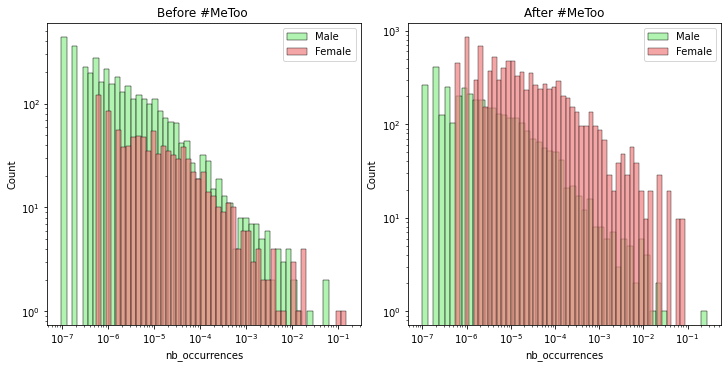

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=2,constrained_layout=True, figsize=(10, 5))
sns.histplot(ax = axs[0], 
                 data = prop_male_before, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightgreen', 
                 alpha = 0.7, 
                 legend = True,
                 stat = 'count')
sns.histplot(ax = axs[0],
                 data = prop_fmale_before, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightcoral', 
                 alpha = 0.7, 
                 legend = True, 
                 stat = 'count')
axs[0].set_title('Before #MeToo ')
axs[0].legend(labels=['Male','Female']);
axs[0].set(yscale = 'log')
sns.histplot(ax = axs[1],
                 data = prop_male_after, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightgreen', 
                 alpha = 0.7, 
                 legend = True, 
                 stat = 'count')
sns.histplot(ax = axs[1],
                 data = prop_fmale_after, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightcoral', 
                 alpha = 0.7, 
                 legend = True, 
                 stat = 'frequency')
axs[1].set_title('After #MeToo')
axs[1].legend(labels=['Male','Female']);
axs[1].set(yscale = 'log')

plt.show()

We observe that the distributions are highly skewed. Thus, we will not use mean neither the standard deviation to compare our distributions. Instead, we will take a look at the median and the geometric means. We will create bootsraped confidence intervals for these estimators.

In [50]:
resume=[]
resume.append(["Female","Before #MeToo",
               fmale_before_metoo['nb_occurrences'].median(), 
               stats.mstats.gmean(fmale_before_metoo['nb_occurrences'], dtype=None), 
               fmale_before_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(fmale_before_metoo['nb_quotes'], dtype=None)
              ])

resume.append(["Male","Before #MeToo",
               male_before_metoo['nb_occurrences'].median(), 
               stats.mstats.gmean(male_before_metoo['nb_occurrences'], dtype=None),
               male_before_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(male_before_metoo['nb_quotes'], dtype=None)])

resume.append(["Female","After #MeToo", fmale_after_metoo['nb_occurrences'].median(),
               stats.mstats.gmean(fmale_after_metoo['nb_occurrences'], dtype=None), 
               fmale_after_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(fmale_after_metoo['nb_quotes'], dtype=None)])
              
resume.append(["Male","After #MeToo", male_after_metoo['nb_occurrences'].median(), 
               stats.mstats.gmean(male_after_metoo['nb_occurrences'], dtype=None),
               male_after_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(male_after_metoo['nb_quotes'], dtype=None)])


Res_mean_med_gmean=pd.DataFrame(resume)  
Res_mean_med_gmean.rename(columns={0: 'Gender', 1: 'Period', 
                                   2:"Median of Occurrences",3: 'Geometric Mean of Occurrences', 
                                   4: 'Median of nb quotes', 5: 'Geometric Mean of nb quotes'}, inplace=True)

Res_mean_med_gmean

,Gender,Period,Median of Occurrences,Geometric Mean of Occurrences,Median of nb quotes,Geometric Mean of nb quotes
0,Female,Before #MeToo,13.0,17.428753,7.0,9.301068
1,Male,Before #MeToo,11.0,15.829479,6.0,8.222666
2,Female,After #MeToo,19.0,29.190302,11.0,14.823034
3,Male,After #MeToo,15.0,21.651458,8.0,11.724268


In [51]:
def bootstrap_CI(data, nbr_draws):
    medians = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        medians[n] = np.median(data_tmp)

    return [np.nanpercentile(medians, 2.5),np.nanpercentile(medians, 97.5)]

In [52]:
med_fem_before = fmale_before_metoo['nb_occurrences'].median()
ci_med_fem_before = bootstrap_CI(fmale_before_metoo['nb_occurrences'],10000)
inf_val_med_fem_before = med_fem_before-ci_med_fem_before[0]
sup_val_med_fem_before = ci_med_fem_before[1]-med_fem_before

med_fem_after = fmale_after_metoo['nb_occurrences'].median()
ci_med_fem_after = bootstrap_CI(fmale_after_metoo['nb_occurrences'],10000)
inf_val_med_fem_after = med_fem_after-ci_med_fem_after[0]
sup_val_med_fem_after = ci_med_fem_after[1]-med_fem_after

med_mal_before = male_before_metoo['nb_occurrences'].median()
ci_med_mal_before = bootstrap_CI(male_before_metoo['nb_occurrences'],10000)
inf_val_med_mal_before = med_mal_before-ci_med_mal_before[0]
sup_val_med_mal_before = ci_med_mal_before[1]-med_mal_before

med_mal_after = male_after_metoo['nb_occurrences'].median()
ci_med_mal_after = bootstrap_CI(male_after_metoo['nb_occurrences'],10000)
inf_val_med_mal_after = med_mal_after-ci_med_mal_after[0]
sup_val_med_mal_after = ci_med_mal_after[1]-med_mal_after

In [53]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='female',
    x=['Before me too', 'After me too'], y=[med_fem_before, med_fem_after],
    error_y=dict(type='data',symmetric = False, array=[sup_val_med_fem_before, sup_val_med_fem_after],
                 arrayminus = [inf_val_med_fem_before,inf_val_med_fem_after])
))
fig.add_trace(go.Bar(
    name='male',
    x=['Before me too', 'After me too'], y=[med_mal_before, med_mal_after],
    error_y=dict(type='data',symmetric = False, array=[sup_val_med_mal_before, sup_val_med_mal_after],
                 arrayminus = [inf_val_med_mal_before,inf_val_med_mal_after])
))
fig.update_layout(barmode='group')
fig.show()

/Users/lisa/opt/anaconda3/envs/ada/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



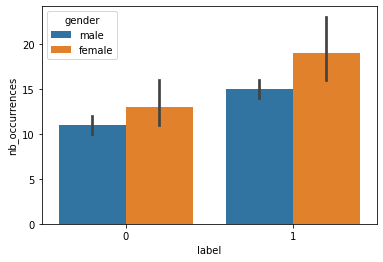

In [54]:
ax = sns.barplot(x="label", y="nb_occurrences", data=balanced_all_genders,hue="gender",estimator=np.median,n_boot=10000)

First, we observe that before #MeToo, women speakers have a median number of quotes and of occurrences higher than men. The geometric means show the same results. This results means even if much more men speak in the news, when a women speak, she has a higher number of quotes and of occurrences attributed to herself. After the movement, the median number of quotes and occurrences of speakers has increased for both male and female speakers. However, we observe a bigger increase for female speakers with a median number of quotes per speaker of 7 before the movement compared to 11 after. The male speakers had also seen their median number of quotes per speaker increased from 6 before to 8 after: the increase is 2 times bigger for the female speakers. Similar results are observed for the number of occurrences per speaker, and the geometric means confirms the findings.

#### Statistical tests by gender 
In order to see if these differences are significant, we will perform some statistical tests. In this context, since our data are not normally distributed, we need to use a non-parametric statistical hypothesis test. We will use the Wilcoxon signed-rank test. The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences is symmetric about zero. In this case, we will perform this test two times: once for female and once for male speakers. In both cases, the null hypothesis is that the median of the population differences (between before and after #MeToo) is zero. The alternative hypothesis is that it is not.

In [55]:
male_diff_occ = pingouin.wilcoxon(male_before_metoo['nb_occurrences'], male_after_metoo['nb_occurrences'])
male_diff_occ['gender'] = 'male'
female_diff_occ = pingouin.wilcoxon(fmale_before_metoo['nb_occurrences'], fmale_after_metoo['nb_occurrences'])
female_diff_occ['gender'] = 'female'

pd.concat([male_diff_occ,female_diff_occ]).set_index('gender')

,W-val,alternative,p-val,RBC,CLES
gender,,,,,
male,2314602.0,two-sided,8.905204e-32,-0.229978,0.457378
female,138984.5,two-sided,2.898956e-22,-0.366114,0.434190


In [56]:
male_diff_quotes = pingouin.wilcoxon(male_before_metoo['nb_quotes'], male_after_metoo['nb_quotes'])
male_diff_quotes['gender'] = 'male'
female_diff_quotes = pingouin.wilcoxon(fmale_before_metoo['nb_quotes'], fmale_after_metoo['nb_quotes'])
female_diff_quotes['gender'] = 'female'

pd.concat([male_diff_quotes,female_diff_quotes]).set_index('gender')

,W-val,alternative,p-val,RBC,CLES
gender,,,,,
male,1718747.0,two-sided,3.253897e-82,-0.383534,0.438995
female,108310.0,two-sided,1.482200e-36,-0.481962,0.424837


Here, we calculated the W-value, the p-value but also two different measures of the effect size:
- matched pairs rank-biserial correlation (RBC): difference between the proportion of favorable and unfavorable evidence. Letting f be the proportion of pairs favorable to the hypothesis, and letting u be the proportion of pairs not favorable, the rank-biserial r is the simple difference between the two proportions: r = f − u
- common language effect size (CLES): proportion of pairs where the number of quotes or occurrences is higher for the speaker after #MeToo than for the speaker before #MeToo.

**Conclusion:** We observe very small p-values in each case, meaning that there is a significant difference in median of the number of quotes and of the number of occurrences before and after the movement, for both genders. Looking at the common language effect size (CLES), we can affirm that for any pairing of speakers before and after the movement, the probability of the speaker after to have more quotes than the speaker before is 0.54 for males and 0.56 for females. The probability of the speaker after to have more occurrences is 0.56 for males and 0.57 for females. The positive rank-biserial correlation (RBC) indicates that those speaking after the movement are quoted more frequently than speakers before the movement.

Thus, we conclude that in general speakers after #MeToo speaks more than speakers before #MeToo. However, even if this phenomenon seems to be a little bit more pronounced for women, we osberve the same trend for both gender. For now, we can affirm that after the movement, speakers talk more in general. We do not osberve a big difference between men and women. We think that our analysis might be too general, so we decide to focus on certain occupations for the rest of the analysis. We will analyze if the profile of the female speakers has changed: whether the professions represented have differed post-Metoo, and once again we will compare this evolution with male speakers.

### A first look at the occupations...

In [57]:
#converts my list into a dict, useful for generation of worldcloud : 
def Convert(lst):
    res_dct = {lst[i][0]: lst[i][0+1] for i in range(0, len(lst))}
    return res_dct

In [58]:
def create_Worldcloud(df,mask_image):
    font_path = 'data/true_south/True South.ttf'
    tupl = [tuple(x) for x in df.values]
    dict_ready = Convert(tupl)
    mask_ = np.array(Image.open(mask_image))
    df_wordcloud = wordcloud.WordCloud(font_path = font_path,width = 500,max_font_size = 300,height=500 ,
                                       background_color="white",relative_scaling = 0.4, max_words=500,
                                       mask=mask_,contour_width=3, 
                                       contour_color='peru').generate_from_frequencies(dict_ready)
    return df_wordcloud

In [59]:
def get_occup (rowss,columns_occ) : 
    list_occ = columns_occ.columns.to_list()
    rowss['occupation']= []
    for i in range(0,len(list_occ)) : 
        if (rowss[list_occ[i]] == 1) :
            rowss['occupation'].append(list_occ[i])
    return (rowss)

In [60]:
balanced_all_genders= balanced_all_genders.apply(lambda row : get_occup(row,dummies_occ),axis=1)

In [61]:
df_occ_female_before=balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender']=='female')].occupation.explode(ignore_index=True)
df_occ_female_after = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'female')].occupation.explode(ignore_index=True)
df_occ_male_before = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'male')].occupation.explode(ignore_index=True)
df_occ_male_after = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'male')].occupation.explode(ignore_index=True)

In [62]:
#Compute the reprensented occupations for female speakers before me too
most_occ_female_before=pd.DataFrame(Counter(df_occ_female_before).most_common(),
                                    columns =['occupation', 'nb_occurences'])

most_occ_male_before = pd.DataFrame(Counter(df_occ_male_before).most_common(),
                                    columns =['occupation', 'nb_occurences'])
most_occ_male_before.dropna(inplace=True)
print(most_occ_female_before.head())
print(most_occ_male_before.head())

#Compute the reprensented occupations for female speakers after me too
most_occ_female_after=pd.DataFrame(Counter(df_occ_female_after).most_common(),
                                   columns =['occupation', 'nb_occurences'])

most_occ_male_after=pd.DataFrame(Counter(df_occ_male_after).most_common(),
                                 columns =['occupation', 'nb_occurences'])

most_occ_male_after.dropna(inplace=True)
print(most_occ_female_after.head())
print(most_occ_male_after.head())

                      occupation  nb_occurences
0         Teaching_and_Education            332
1                     Government            257
2                      Scientist            234
3                     Literature            193
4  Social_Sciences_and_Ethnology            141
                      occupation  nb_occurences
0         Teaching_and_Education           1439
1                     Government           1004
2                      Scientist            908
3  Social_Sciences_and_Ethnology            777
4                     Literature            677
                      occupation  nb_occurences
0         Teaching_and_Education            316
1                     Government            263
2                      Scientist            244
3                     Literature            179
4  Social_Sciences_and_Ethnology            140
                      occupation  nb_occurences
0         Teaching_and_Education           1448
1                     Government        

In [63]:
most_occ_female_before['occupation'].replace({'Teaching_and_Education':'Teaching',
                                              'Social_Sciences_and_Ethnology': 'Social_sciences',
                                              'Media_and_Journalism':'Media'},inplace=True)

most_occ_female_after['occupation'].replace({'Teaching_and_Education':'Teaching',
                                             'Social_Sciences_and_Ethnology': 'Social_sciences',
                                             'Media_and_Journalism':'Media'},inplace=True)

most_occ_male_before['occupation'].replace({'Teaching_and_Education':'Teaching',
                                            'Social_Sciences_and_Ethnology': 'Social_sciences',
                                            'Media_and_Journalism':'Media'},inplace=True)

most_occ_male_after['occupation'].replace({'Teaching_and_Education':'Teaching',
                                           'Social_Sciences_and_Ethnology': 'Social_sciences',
                                           'Media_and_Journalism':'Media'},inplace=True)
"""
proposition plus concise:

for c in [most_occ_female_before, most_occ_female_after, most_occ_male_before, most_occ_male_after]:
    
    c['occupation'].replace({'Teaching_and_Education':'Teaching',
                            'Social_Sciences_and_Ethnology': 'Social_sciences',
                            'Media_and_Journalism':'Media'},inplace=True)


"""

"\nproposition plus concise:\n\nfor c in [most_occ_female_before, most_occ_female_after, most_occ_male_before, most_occ_male_after]:\n    \n    c['occupation'].replace({'Teaching_and_Education':'Teaching',\n                            'Social_Sciences_and_Ethnology': 'Social_sciences',\n                            'Media_and_Journalism':'Media'},inplace=True)\n\n\n"

In [64]:
#before me too
Worldcloud_before_fem = create_Worldcloud(most_occ_female_before, 'data/female.png')
Worldcloud_before_mal = create_Worldcloud(most_occ_male_before,'data/male.png')

#after me too
Worldcloud_after_fem = create_Worldcloud(most_occ_female_after,'data/female.png')
Worldcloud_after_mal = create_Worldcloud(most_occ_male_after,'data/male.png')

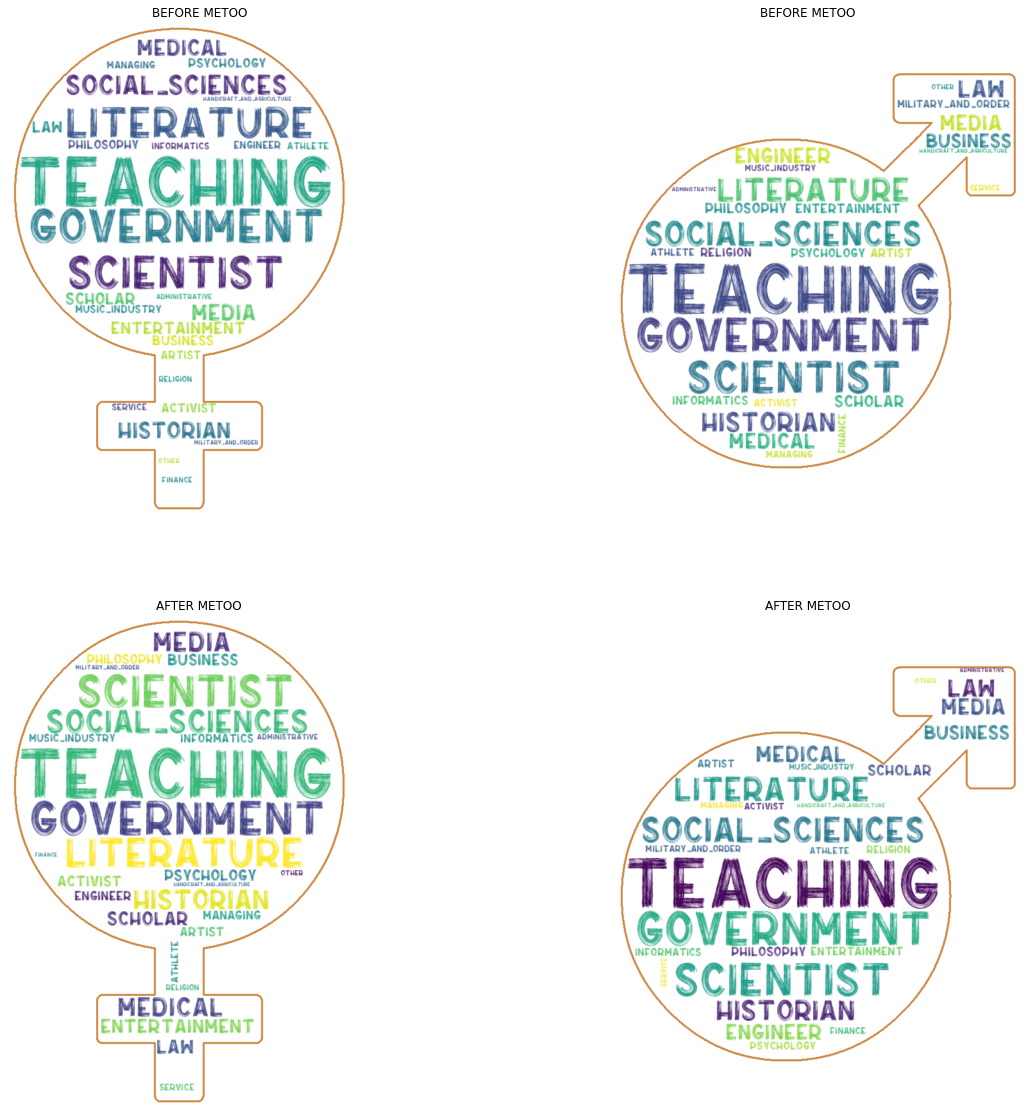

In [65]:
fig,ax = plt.subplots(2,2, figsize=(20,20))
ax[0,0].imshow(Worldcloud_before_fem, cmap=plt.cm.gray, interpolation="bilinear")
ax[0,0].axis("off")
ax[0,0].set_title('BEFORE METOO')
ax[0,1].imshow(Worldcloud_before_mal, cmap=plt.cm.gray, interpolation="bilinear")
ax[0,1].set_title('BEFORE METOO')
ax[0,1].axis("off")
ax[1,0].imshow(Worldcloud_after_fem, cmap=plt.cm.gray, interpolation="bilinear")
ax[1,0].set_title('AFTER METOO')
ax[1,0].axis("off")
ax[1,1].imshow(Worldcloud_after_mal, cmap=plt.cm.gray, interpolation="bilinear")
ax[1,1].set_title('AFTER METOO')
ax[1,1].axis("off")
plt.show()

### Comparison between men and women speakers by category of occupation

Following our matching process, we create one dataset per balanced occupation

In [66]:
balanced_teaching = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Teaching_and_Education.json.bz2'), 
                               speakers_twice])

balanced_government = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Government.json.bz2'), 
                               speakers_twice])

balanced_scientist = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Scientist.json.bz2'), 
                               speakers_twice])

balanced_social_sciences=pd.concat([pd.read_json(DATA_FOLDER+'results/balanced_Social_Sciences_and_Ethnology.json.bz2'), 
                               speakers_twice])

balanced_literature = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Literature.json.bz2'), 
                               speakers_twice])

balanced_historian = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Historian.json.bz2'), 
                               speakers_twice])

balanced_law = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Law.json.bz2'), 
                               speakers_twice])

balanced_media = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Media_and_Journalism.json.bz2'), 
                               speakers_twice])


In [67]:
cat=[balanced_teaching, balanced_government, balanced_scientist, balanced_social_sciences,balanced_literature,
    balanced_historian, balanced_law, balanced_media]

cat_names=["Teaching_and_Education", "Government", "Scientist", "Social_Sciences_and_Ethnology","Literature",
           "Historian", "Law", "Media_and_Journalism"]

cat_non_names=["Non_Teaching_and_Education", "Non_Government", "Non_Scientist", "Non_Social_Sciences_and_Ethnology",
               "Non_Literature", "Non_Historian", "Non_Law", "Non_Media_and_Journalism"]


For each occupation, we show the geometric mean of the number of quotes depending on:
- The gender
- The occupation status of the speaker for the specified occupation
    - 0: The speaker doesn't work in this occupation field
    - 1: The speaker works in this occupation field
- The label:
    - 0: Before #MeToo
    - 1: After #MeToo

In [68]:
def tablegmeans(c,name):
    print(("\033[1m" + "Occupation: " + name + "\033[0m").center(100))
    print('\n')
    print(pd.crosstab(c.label, [c.gender, c[name]]))
    print('\n')
    gmean_occupations(c, name, 'nb_quotes')

In [69]:
k=0
for c in cat:
    tablegmeans(c,cat_names[k])
    print("\n")
    k+=1

                             Occupation: Teaching_and_Education                             


gender                 female       male      
Teaching_and_Education      0    1     0     1
label                                         
0                         651  321  2200  1439
1                         651  321  2200  1439


GEOMETRIC MEANS
Male speakers
                              Before #MeToo    After #MeToo
--------------------------  ---------------  --------------
Non Teaching_and_Education          8.92368         12.9206
Teaching_and_Education              7.25589         10.0746


Female speakers
                              Before #MeToo    After #MeToo
--------------------------  ---------------  --------------
Non Teaching_and_Education         10.248           17.4888
Teaching_and_Education              7.94348         10.9829


                                   Occupation: Government                                   


gender     female       male      
Governme

In [70]:
#Function to build a dataFrame for a specific balanced_occupation, classify speakers between occupation and non_occupation
def create_dF_category(c,name,non_name):
    yes=c[(c[name] == 1)][['nb_quotes','nb_occurrences','label','gender',name]]
    dfYes=pd.DataFrame(yes)
    dfYes['Occupation'] = name
    no=c[(c[name] == 0)][['nb_quotes','nb_occurrences','label','gender',name]]
    dfNo=pd.DataFrame(no)
    dfNo['Occupation'] = non_name
    Full=pd.concat([dfYes,dfNo])
    return Full    

In [71]:
#Creation of one dataFrame for each occupation
fulls=[]
j=0
for n in range(8):
    full=create_dF_category(cat[j],cat_names[j],cat_non_names[j])
    full['label'].replace({0:"Before #MeToo",1:"After #MeToo"},inplace=True)
    fulls.append(full)
    j+=1


In [72]:
#Function to build a dataFrame for each balanced_occupation with only the speakers who performed this occupation
def create_dF_yes(c,name,non_name):
    yes=c[(c[name] == 1)][['nb_quotes','nb_occurrences','label','gender',name]]
    dfYes=pd.DataFrame(yes)
    dfYes['Occupation'] = name
    return dfYes


In [73]:
#Creation of one dataframe per occupation with only the positive occupation concatenation of all the dataframes
yey=[]
j=0
for n in range(8):
    e=create_dF_yes(cat[j],cat_names[j],cat_non_names[j])
    e.drop([cat_names[j]], axis = 1, inplace = True)
    yey.append(e)
    j+=1
ye=pd.concat(yey)


In [74]:
ye.replace({"Teaching_and_Education": "Teaching",
             "Social_Sciences_and_Ethnology":"Social_Sciences",
            "Media_and_Journalism":"Media"},inplace=True)

ye['label'].replace({0:"Before #MeToo",1:"After #MeToo"},inplace=True)

In [75]:
#data frame that repertoriates for each gender, period and occupation the proportion of the number of quotes
#fpr this occupation among others
i=0
l=[]
for f in fulls:    
    a=f[(f['gender'] == "female")&(f['Occupation'] == cat_names[i])&
               (f['label'] == "Before #MeToo")].nb_quotes.sum()
    b=f[(f['gender'] == "female")&(f['Occupation'] == cat_non_names[i])&
               (f['label'] == "Before #MeToo")].nb_quotes.sum()
    
    l.append(["Female",a/(a+b),"Before #MeToo",cat_names[i]])

    c=f[(f['gender'] == "female")&(f['Occupation'] == cat_names[i])&
               (f['label'] == "After #MeToo")].nb_quotes.sum()
    d=f[(f['gender'] == "female")&(f['Occupation'] == cat_non_names[i])&
               (f['label'] == "After #MeToo")].nb_quotes.sum()

    l.append(["Female",c/(c+d),"After #MeToo",cat_names[i]])

    a=f[(f['gender'] == "male")&(f['Occupation'] == cat_names[i])&
               (f['label'] == "Before #MeToo")].nb_quotes.sum()
    b=f[(f['gender'] == "male")&(f['Occupation'] == cat_non_names[i])&
               (f['label'] == "Before #MeToo")].nb_quotes.sum()
    
    l.append(["Male",a/(a+b),"Before #MeToo",cat_names[i]])

    c=f[(f['gender'] == "male")&(f['Occupation'] == cat_names[i])&
               (f['label'] == "After #MeToo")].nb_quotes.sum()
    d=f[(f['gender'] == "male")&(f['Occupation'] == cat_non_names[i])&
               (f['label'] == "After #MeToo")].nb_quotes.sum()

    l.append(["Male",c/(c+d),"After #MeToo",cat_names[i]])



    i+=1
prop=pd.DataFrame(l)

prop.rename(columns={0: 'Gender', 1: 'Proportion', 
                                   2:"Label",3: 'Occupation'},inplace=True)

prop.replace({"Teaching_and_Education": "Teaching",
             "Social_Sciences_and_Ethnology":"Social_Sciences",
            "Media_and_Journalism":"Media"},inplace=True)

#### Proportion Number of quotes of a specific occupations among others

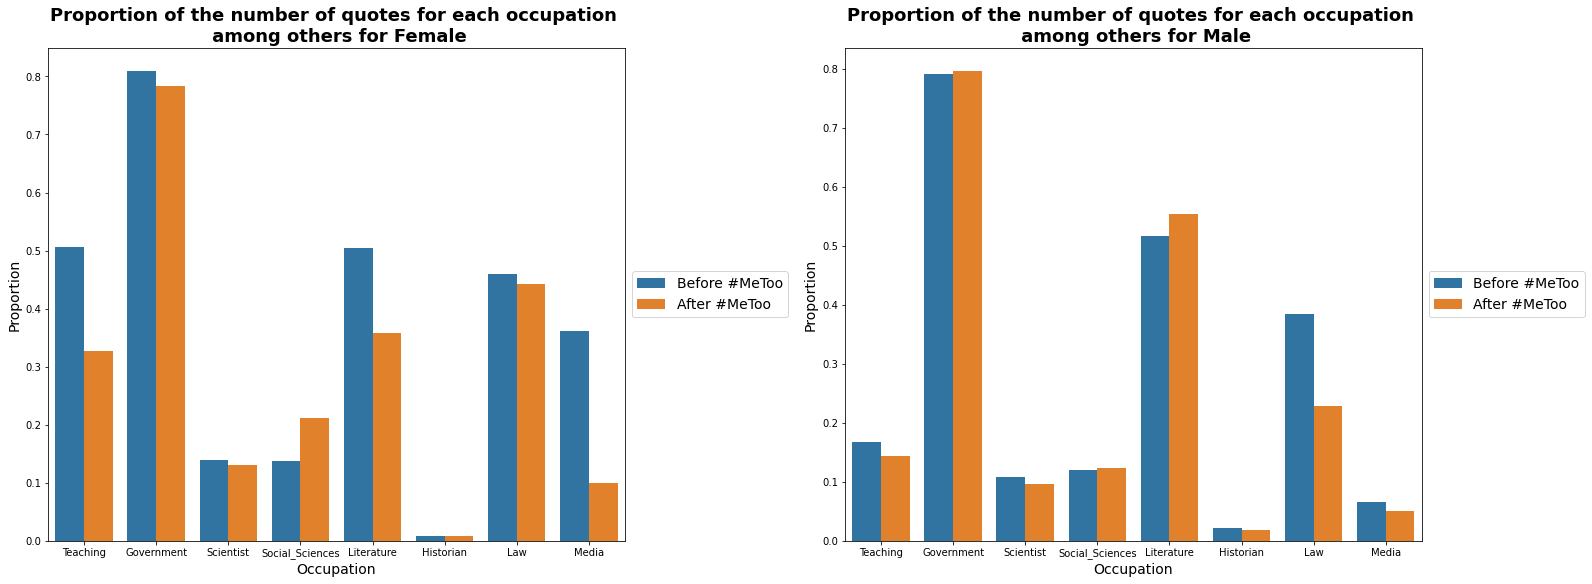

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'Proportion', hue = 'Label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = prop[(prop['Gender'] == "Female")]);

ax[0].set_ylabel('Proportion',fontsize=14)
ax[0].set_xlabel("Occupation",fontsize=14)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[0].set_title('Proportion of the number of quotes for each occupation \n among others for Female', 
                fontsize=18,fontweight="bold");


sns.barplot(ax=ax[1],x = 'Occupation', y = 'Proportion', hue = 'Label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = prop[(prop['Gender'] == "Male")]);

ax[1].set_ylabel('Proportion',fontsize=14)
ax[1].set_xlabel("Occupation",fontsize=14)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[1].set_title('Proportion of the number of quotes for each occupation \n among others for Male', 
                fontsize=18,fontweight="bold");


#### Geometric mean of the number of quotations  for all occupations before and after #MeToo for each gender.
We plot the geometric mean of the number of quotations for each occupation before and after the #MeToo movement and for each gender

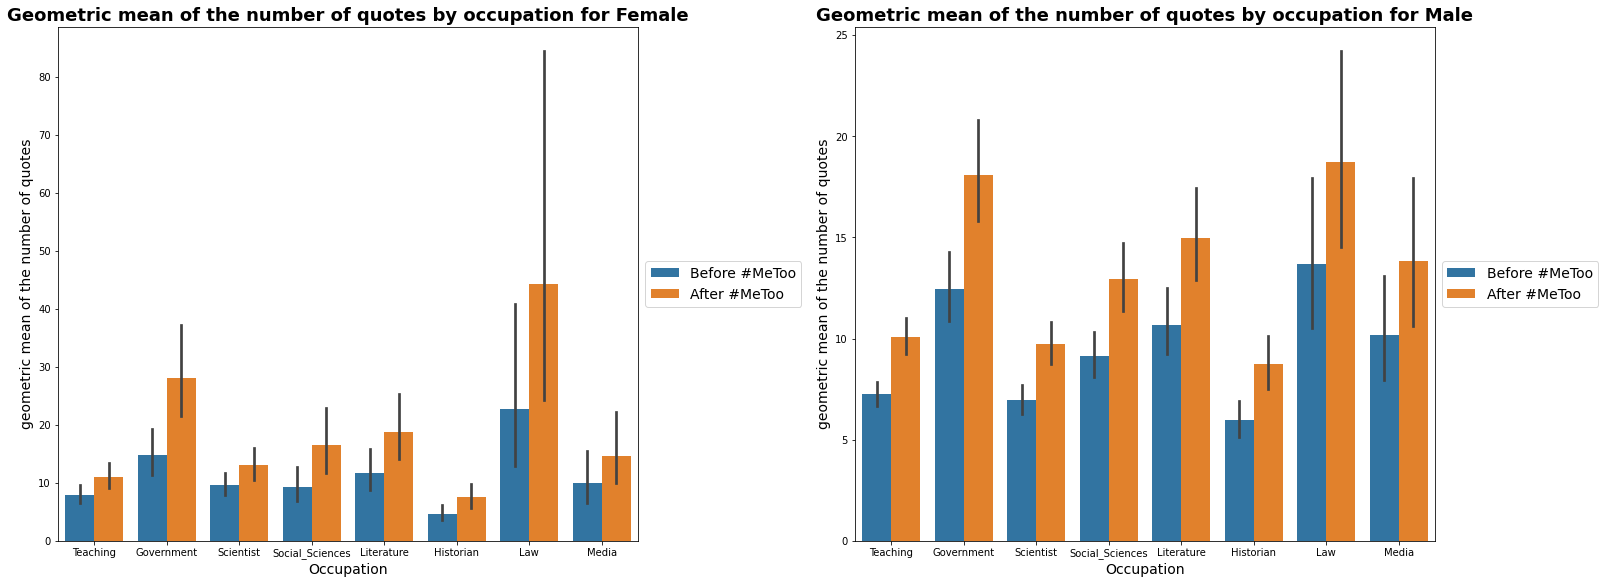

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_quotes', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);

ax[0].set_ylabel('geometric mean of the number of quotes',fontsize=14)
ax[0].set_xlabel("Occupation",fontsize=14)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[0].set_title('Geometric mean of the number of quotes by occupation for Female', fontsize=18,fontweight="bold");


sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_quotes', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);

ax[1].set_ylabel('geometric mean of the number of quotes',fontsize=14)
ax[1].set_xlabel("Occupation",fontsize=14)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[1].set_title('Geometric mean of the number of quotes by occupation for Male', fontsize=18,fontweight="bold");


#### Geometric mean of the number of occurences of quotation  for all occupations before and after #MeToo for each gender.
We plot the geometric mean of the number of occurences for each occupation before and after the #MeToo movement and for each gender

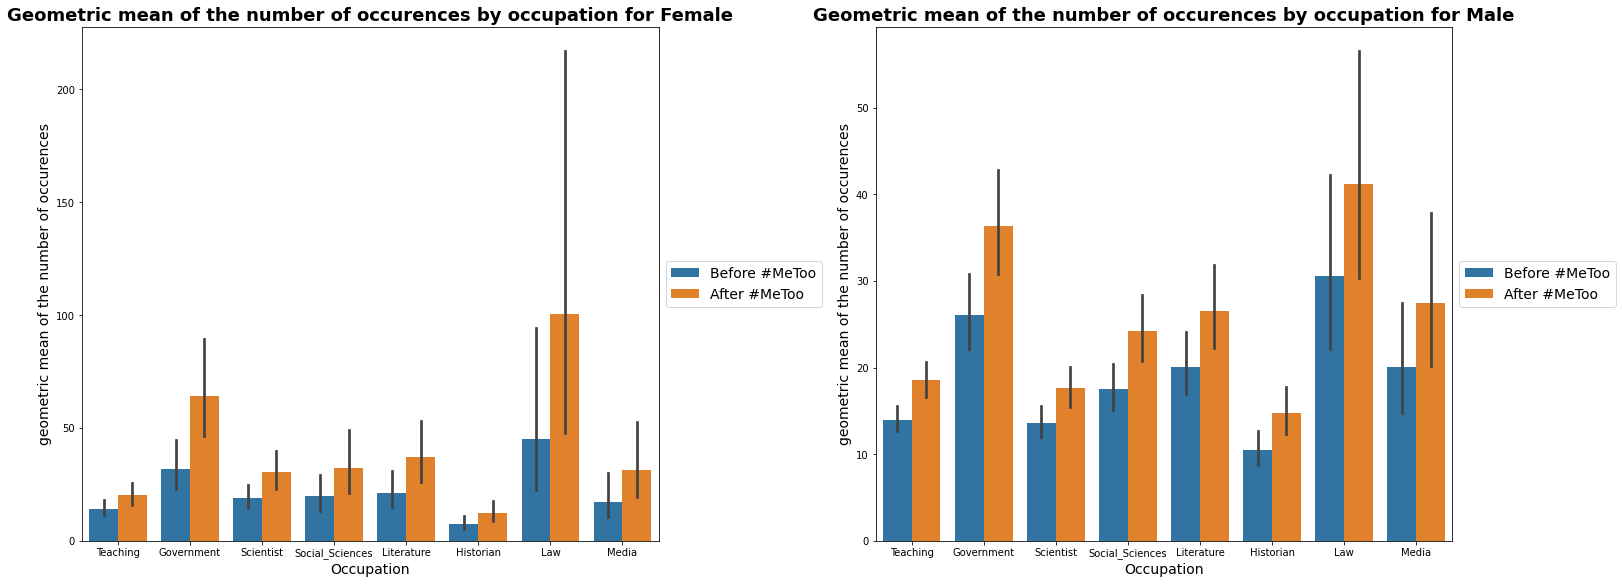

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);

ax[0].set_ylabel('geometric mean of the number of occurences',fontsize=14)
ax[0].set_xlabel("Occupation",fontsize=14)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[0].set_title('Geometric mean of the number of occurences by occupation for Female',fontsize=18,fontweight="bold");


sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);

ax[1].set_ylabel('geometric mean of the number of occurences',fontsize=14)
ax[1].set_xlabel("Occupation",fontsize=14)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[1].set_title('Geometric mean of the number of occurences by occupation for Male',fontsize=18,fontweight="bold");


#### Median of the number of quotations  for all occupations before and after #MeToo for each gender.
We plot the median of the number of quotations for each occupation before and after the #MeToo movement and for each gender

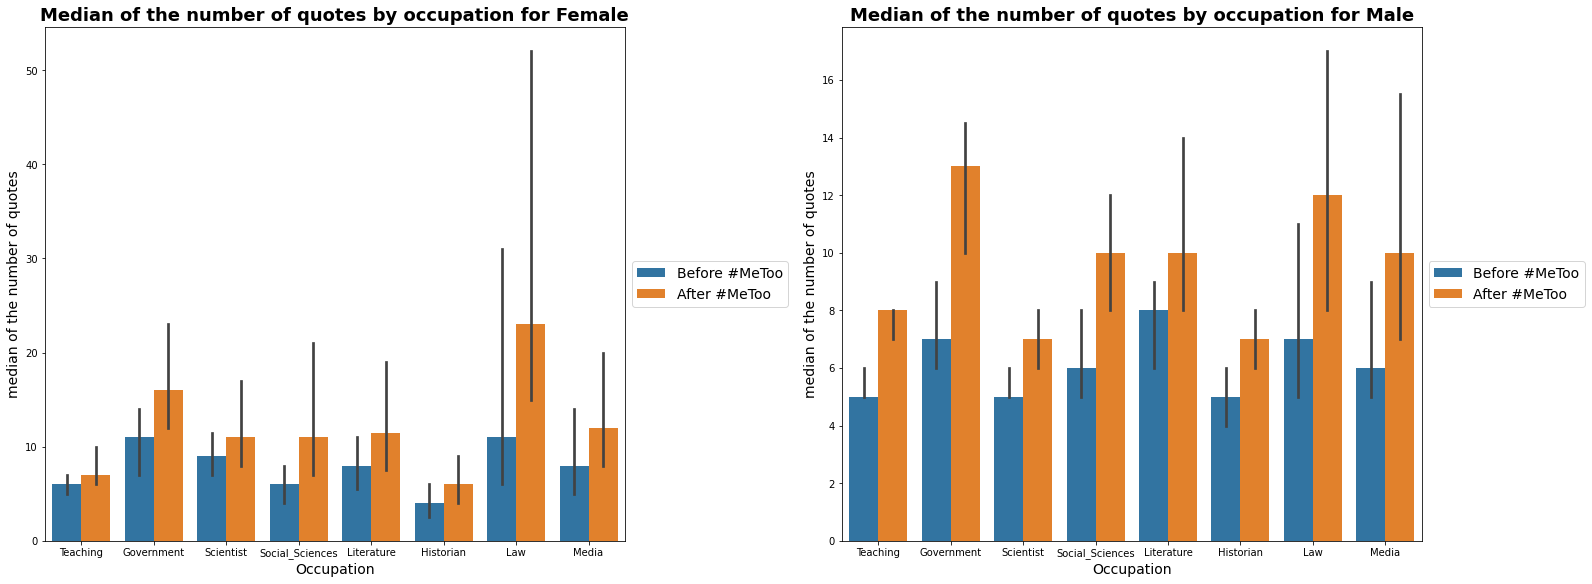

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_quotes', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "female")], estimator=np.median,n_boot=10000);

ax[0].set_ylabel('median of the number of quotes',fontsize=14)
ax[0].set_xlabel("Occupation",fontsize=14)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[0].set_title('Median of the number of quotes by occupation for Female',fontsize=18,fontweight="bold");

sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_quotes', hue = 'label', 
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "male")], estimator=np.median,n_boot=10000);

ax[1].set_ylabel('median of the number of quotes',fontsize=14)
ax[1].set_xlabel("Occupation",fontsize=14)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[1].set_title('Median of the number of quotes by occupation for Male',fontsize=18,fontweight="bold");

#### Median of the number of occurences  for all occupations before and after #MeToo for each gender.
We plot the median of the number of occurences for each occupation before and after the #MeToo movement and for each gender

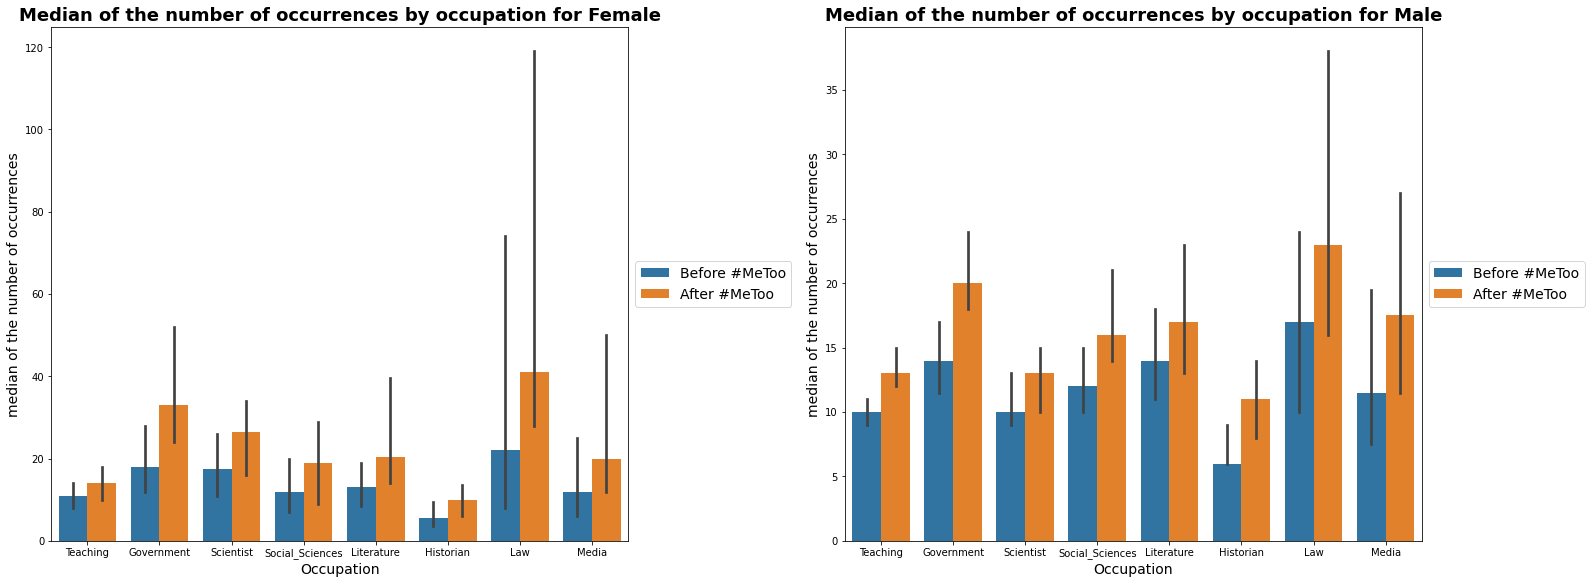

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "female")], estimator=np.median,n_boot=10000);

ax[0].set_ylabel('median of the number of occurrences',fontsize=14)
ax[0].set_xlabel("Occupation",fontsize=14)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[0].set_title('Median of the number of occurrences by occupation for Female',fontsize=18,fontweight="bold");

sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "male")], estimator=np.median,n_boot=10000);

ax[1].set_ylabel('median of the number of occurrences',fontsize=14)
ax[1].set_xlabel("Occupation",fontsize=14)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[1].set_title('Median of the number of occurrences by occupation for Male',fontsize=18,fontweight="bold");

#### Geometric mean of the number of quotations per occupation and per gender

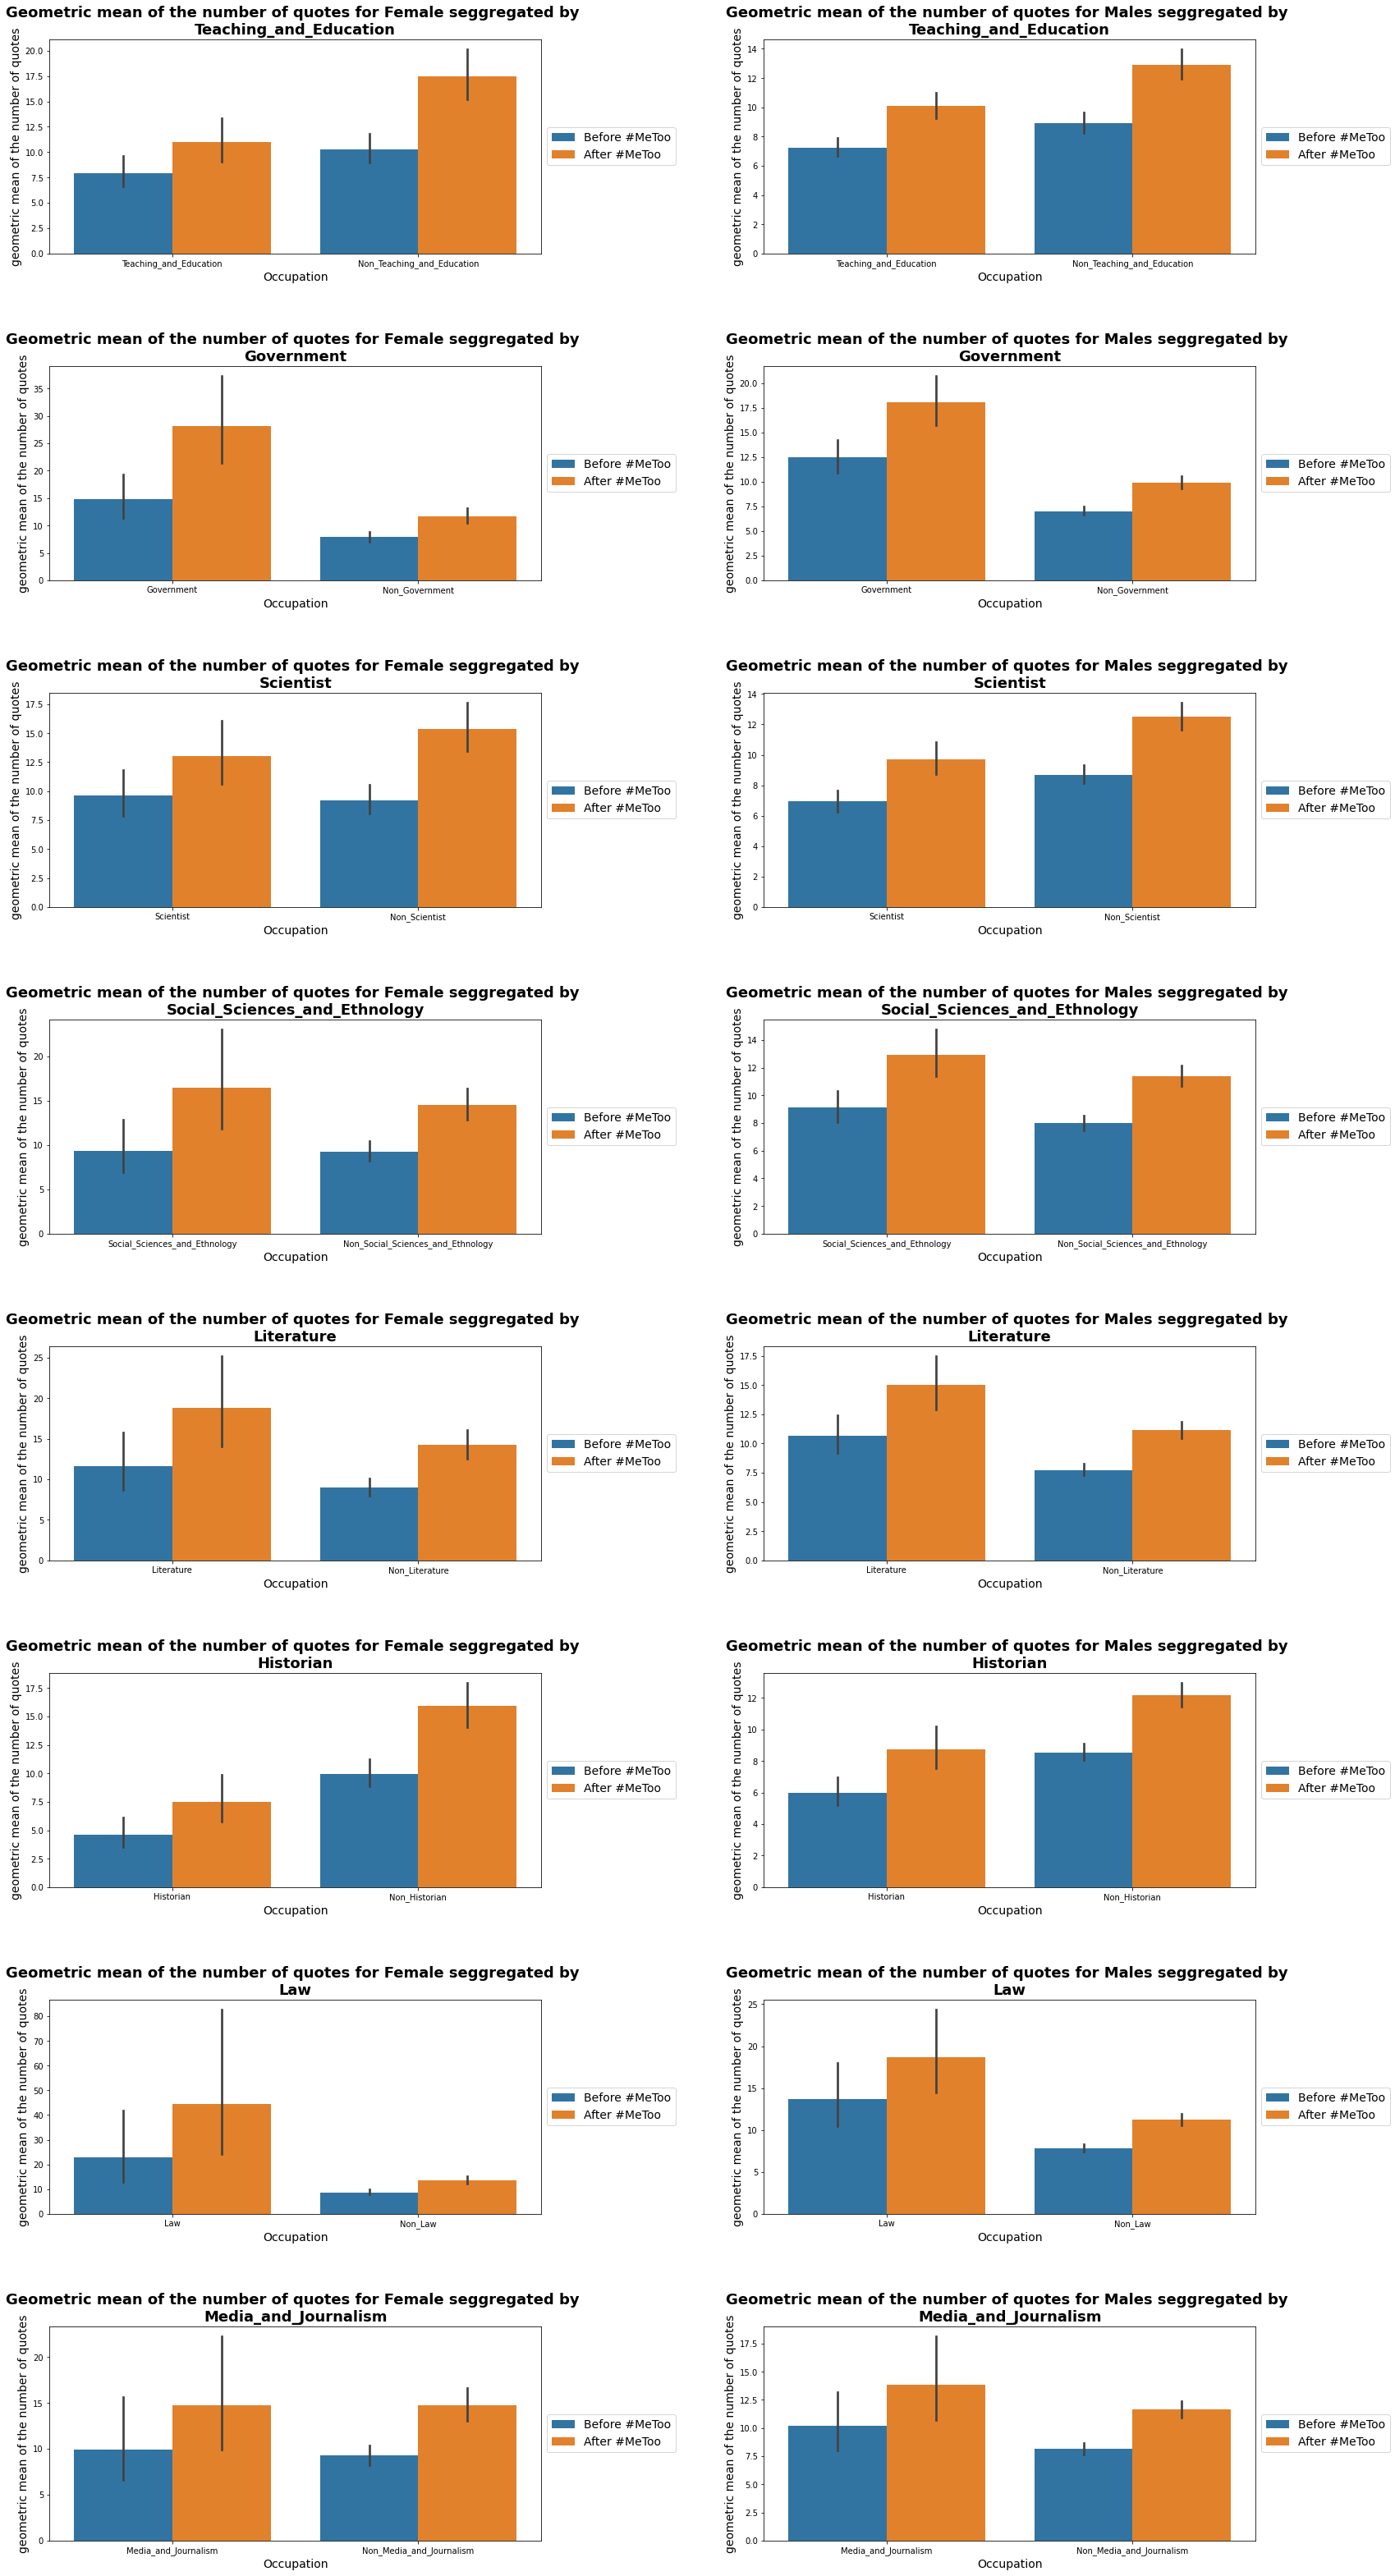

In [81]:
fig, ax = plt.subplots(nrows=8, ncols=2, constrained_layout=False, figsize=(25, 45));
i=0
for f in fulls:
    sns.barplot(ax=ax[i,0], x = 'Occupation', y = 'nb_quotes', hue = 'label',
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);
    
    sns.barplot(ax=ax[i,1], x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);
    
    fig.tight_layout(pad=6.0)
    
    ax[i,0].set_ylabel('geometric mean of the number of quotes',fontsize=14);
    ax[i,0].set_xlabel("Occupation",fontsize=14)
    ax[i,0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,0].set_title('Geometric mean of the number of quotes for Female seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");

    
    ax[i,1].set_ylabel('geometric mean of the number of quotes',fontsize=14);
    ax[i,1].set_xlabel("Occupation",fontsize=14)
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,1].set_title('Geometric mean of the number of quotes for Males seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");

    i+=1

#### Median of the number of quotations per occupation and per gender

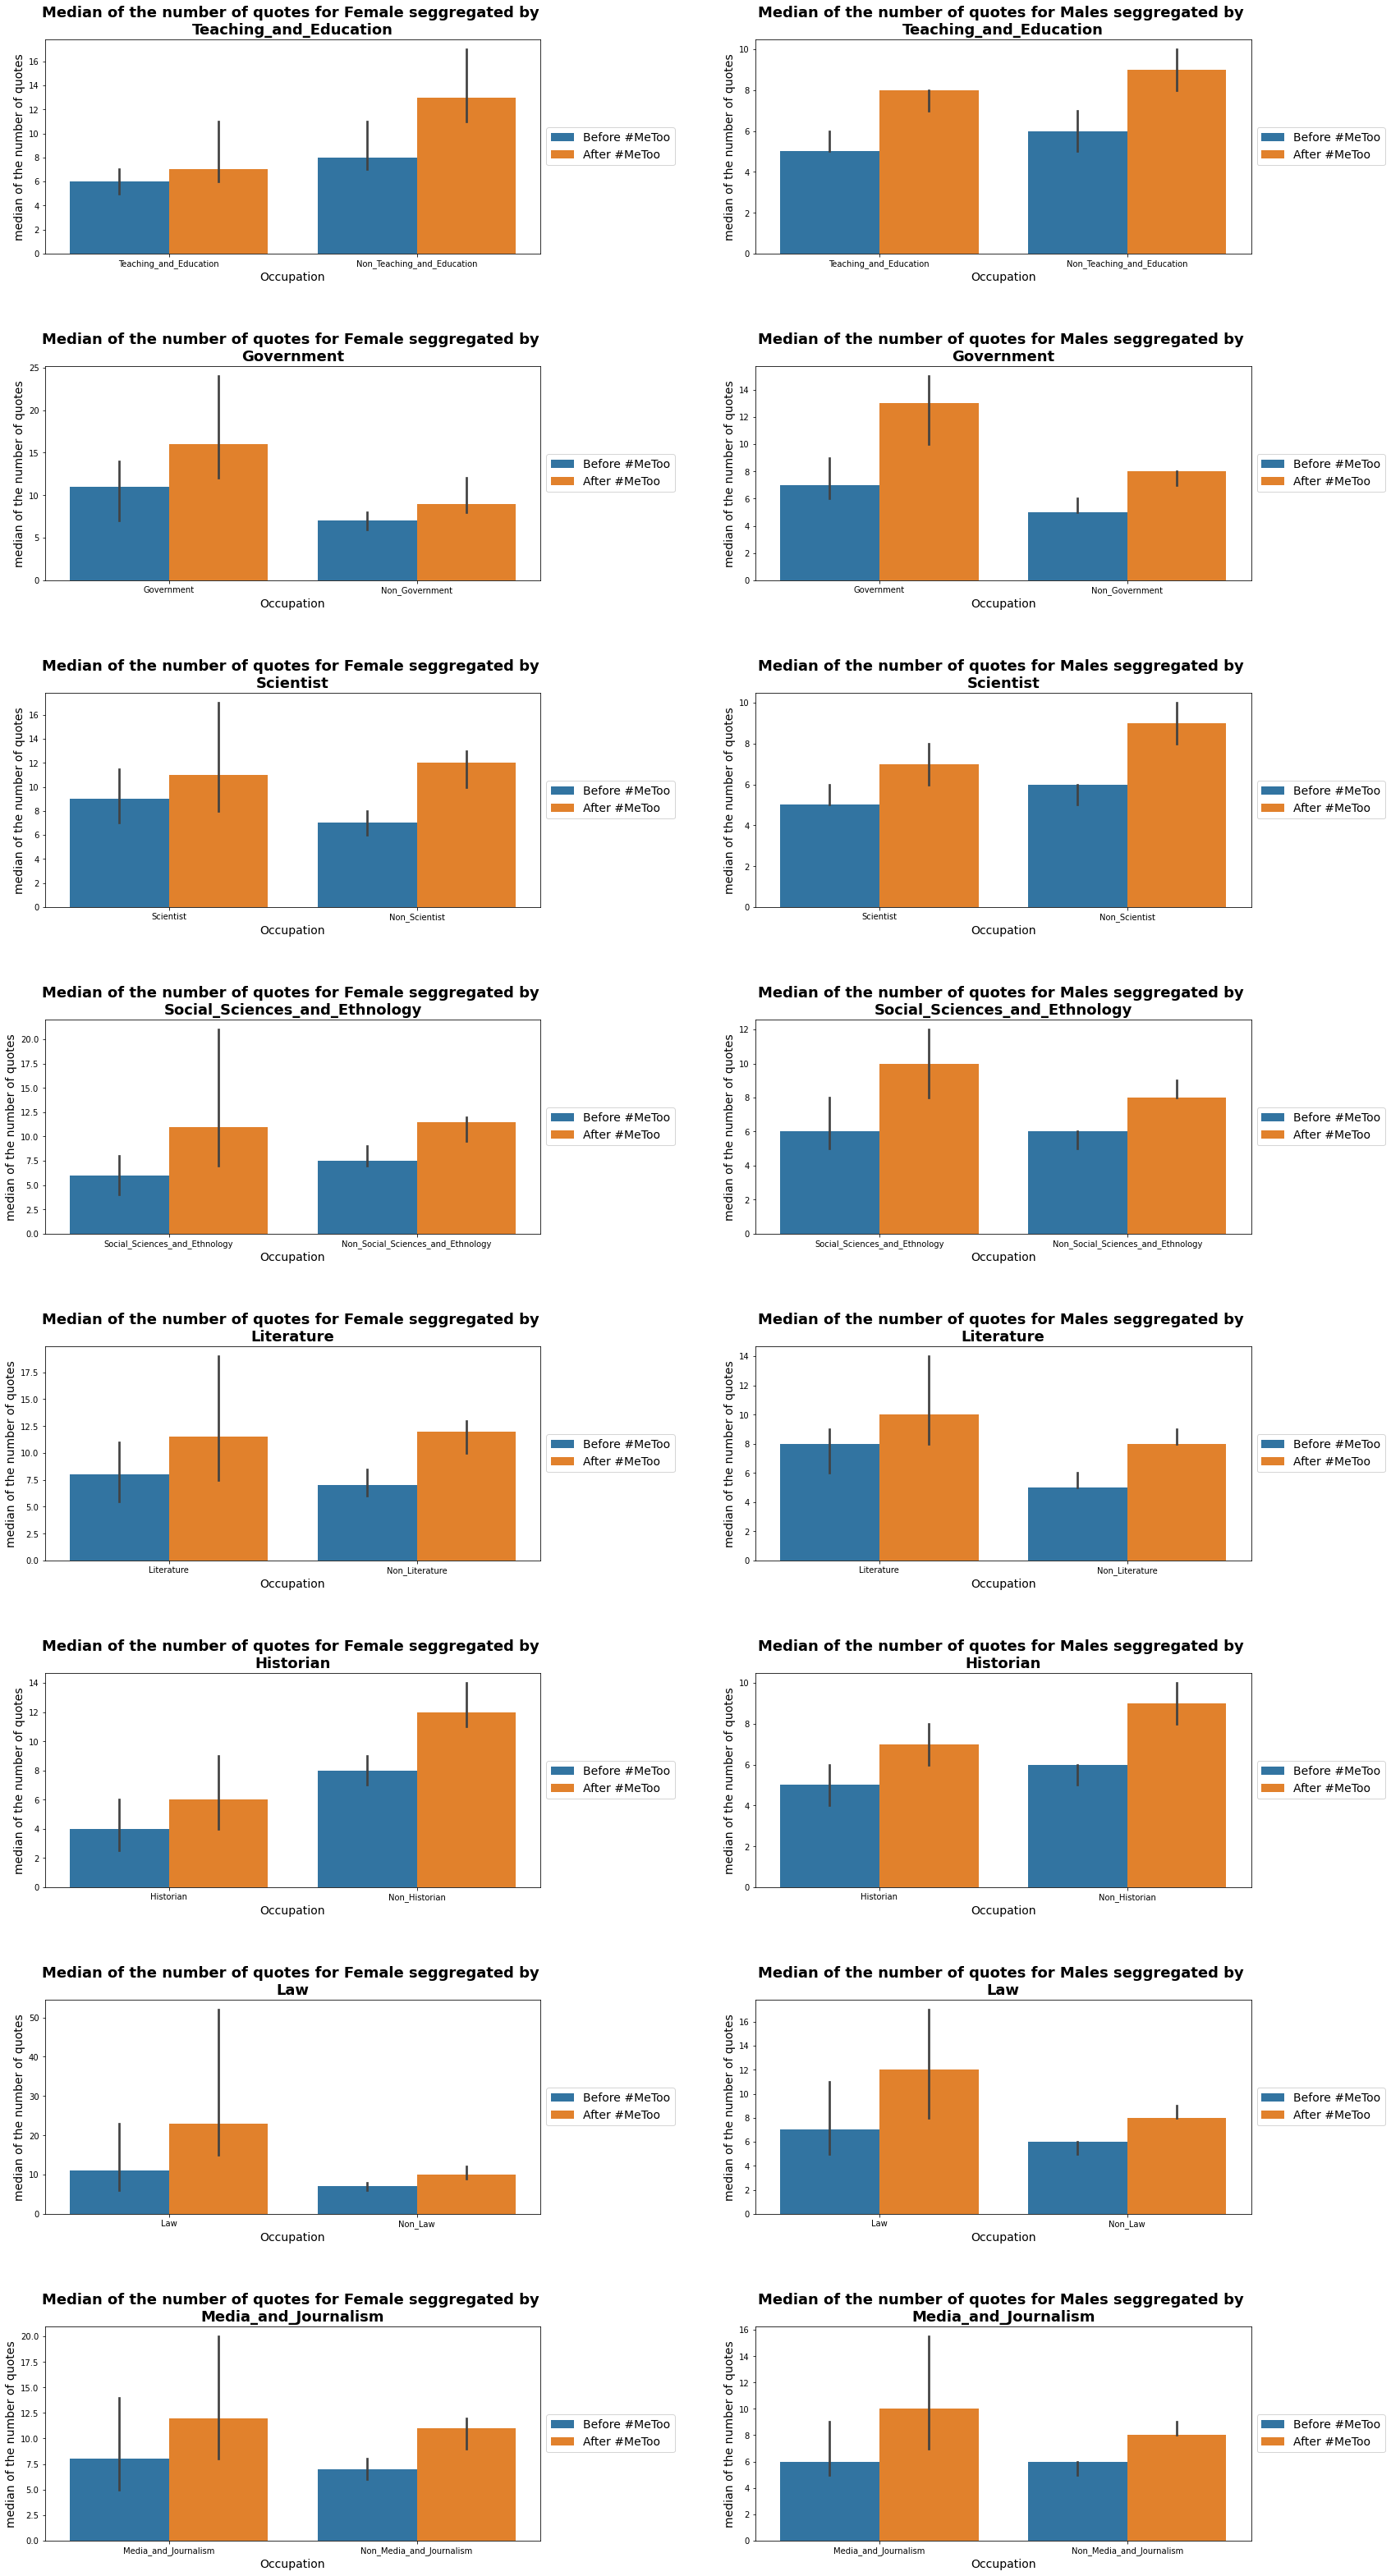

In [82]:
fig, ax = plt.subplots(nrows=8, ncols=2, constrained_layout=False, figsize=(25, 45));
i=0

for f in fulls:
    
    sns.barplot(ax=ax[i,0], x = 'Occupation', y = 'nb_quotes', hue = 'label',
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "female")], estimator=np.median,n_boot=10000);
    
    sns.barplot(ax=ax[i,1], x = 'Occupation', y = 'nb_quotes', hue = 'label',
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "male")], estimator=np.median,n_boot=10000);
    
    fig.tight_layout(pad=6.0)
    
    ax[i,0].set_ylabel('median of the number of quotes',fontsize=14);
    ax[i,0].set_xlabel("Occupation",fontsize=14)
    ax[i,0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,0].set_title('Median of the number of quotes for Female seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");

    
    ax[i,1].set_ylabel('median of the number of quotes',fontsize=14);
    ax[i,1].set_xlabel("Occupation",fontsize=14)
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,1].set_title('Median of the number of quotes for Males seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");
    i+=1


#### Statistical tests by both occupation and gender
Let's see if these differences in median number of quotes is significant for every occupation and for every gender. Here again, we use the Wilcoxon signed-rank test. In this case, we will perform this test: once for female and once for male speakers, for every category of occupation. In each case, the null hypothesis is that the median of the population differences (between before and after #MeToo) is zero. The alternative hypothesis is that it is not.

In [83]:
def wilcoxon_by_category(c, name, non_name):
    df_wilcox = create_dF_category(c, name, non_name)
    df_wilcox_cat  = df_wilcox[df_wilcox['Occupation'] == name]
    df_wilcox_non_cat = df_wilcox[df_wilcox['Occupation'] == non_name]

    #Male, occ = yes
    male_diff_occ = pingouin.wilcoxon(df_wilcox_cat[(df_wilcox_cat['label'] == 1) & 
                                                    (df_wilcox_cat['gender'] == 'male')]['nb_quotes'], 
                                      df_wilcox_cat[(df_wilcox_cat['label'] == 0) & 
                                                    (df_wilcox_cat['gender'] == 'male')]['nb_quotes'])
    male_diff_occ['gender'] = 'male'
    male_diff_occ['Occupation'] = name

    #Male, occ = no
    male_diff_non_occ = pingouin.wilcoxon(df_wilcox_non_cat[(df_wilcox_non_cat['label'] == 1) & 
                                                    (df_wilcox_non_cat['gender'] == 'male')]['nb_quotes'], 
                                      df_wilcox_non_cat[(df_wilcox_non_cat['label'] == 0) & 
                                                    (df_wilcox_non_cat['gender'] == 'male')]['nb_quotes'])
    male_diff_non_occ['gender'] = 'male'
    male_diff_non_occ['Occupation'] = non_name


    #Female, occ = yes
    female_diff_occ = pingouin.wilcoxon(df_wilcox_cat[(df_wilcox_cat['label'] == 1) & 
                                                    (df_wilcox_cat['gender'] == 'female')]['nb_quotes'], 
                                      df_wilcox_cat[(df_wilcox_cat['label'] == 0) & 
                                                    (df_wilcox_cat['gender'] == 'female')]['nb_quotes'])
    female_diff_occ['gender'] = 'female'
    female_diff_occ['Occupation'] = name

    #Female, occ = no
    female_diff_non_occ = pingouin.wilcoxon(df_wilcox_non_cat[(df_wilcox_non_cat['label'] == 1) & 
                                                    (df_wilcox_non_cat['gender'] == 'female')]['nb_quotes'], 
                                      df_wilcox_non_cat[(df_wilcox_non_cat['label'] == 0) & 
                                                    (df_wilcox_non_cat['gender'] == 'female')]['nb_quotes'])
    female_diff_non_occ['gender'] = 'female'
    female_diff_non_occ['Occupation'] = non_name


    return pd.concat([male_diff_occ, male_diff_non_occ, 
               female_diff_occ, female_diff_non_occ]).set_index(['gender', 'Occupation'])

In [84]:
wilcoxon = []
for c, name, non_name in zip(cat, cat_names, cat_non_names):
    wilcoxon.append(wilcoxon_by_category(c, name, non_name))

wilcoxon_results = pd.concat(wilcoxon)
wilcoxon_results

W-val alternative         p-val  \
gender Occupation                                                               
male   Teaching_and_Education              279379.0   two-sided  6.004361e-28   
       Non_Teaching_and_Education          622657.5   two-sided  1.875376e-54   
female Teaching_and_Education               13224.5   two-sided  4.259009e-09   
       Non_Teaching_and_Education           47631.5   two-sided  1.842059e-27   
male   Government                          141091.5   two-sided  3.534825e-20   
       Non_Government                      872094.5   two-sided  1.427405e-63   
female Government                            7037.0   two-sided  4.723549e-13   
       Non_Government                       62843.5   two-sided  1.169607e-23   
male   Scientist                           107983.5   two-sided  1.706968e-19   
       Non_Scientist                       958879.5   two-sided  4.671387e-64   
female Scientist                             7181.5   two-sided  5.226120e-07   
       Non_Scientist                        60630.5   two-sided  1.751798e-30   
male   Social_Sciences_and_Ethnology        72748.5   two-sided  2.054758e-22   
       Non_Social_Sciences_and_Ethnology  1096211.5   two-sided  1.066986e-61   
female Social_Sciences_and_Ethnology         1546.5   two-sided  1.371900e-09   
       Non_Social_Sciences_and_Ethnology    84809.0   two-sided  1.271300e-27   
male   Literature                           58775.0   two-sided  4.318169e-17   
       Non_Literature                     1152177.5   two-sided  8.129368e-67   
female Literature                            3431.0   two-sided  1.658095e-08   
       Non_Literature                       71329.0   two-sided  1.197125e-28   
male   Historian                            20466.0   two-sided  2.123748e-10   
       Non_Historian                      1365867.0   two-sided  6.142441e-74   
female Historian                             1023.0   two-sided  4.147549e-03   
       Non_Historian                        88002.0   two-sided  2.288786e-34   
male   Law                                  15096.0   two-sided  2.657791e-05   
       Non_Law                            1405199.0   two-sided  5.195274e-79   
female Law                                    507.5   two-sided  1.671034e-03   
       Non_Law                              96649.0   two-sided  9.577980e-33   
male   Media_and_Journalism                  6769.5   two-sided  6.212406e-05   
       Non_Media_and_Journalism           1504038.5   two-sided  1.467305e-78   
female Media_and_Journalism                  1011.5   two-sided  6.262404e-02   
       Non_Media_and_Journalism             88240.5   two-sided  1.296956e-35   

                                               RBC      CLES  
gender Occupation                                             
male   Teaching_and_Education             0.349302  0.557694  
       Non_Teaching_and_Education         0.397689  0.562646  
female Teaching_and_Education             0.394205  0.551703  
       Non_Teaching_and_Education         0.503554  0.584745  
male   Government                         0.348179  0.557440  
       Non_Government                     0.396141  0.561861  
female Government                         0.532968  0.589252  
       Non_Government                     0.445827  0.567682  
male   Scientist                          0.363072  0.560360  
       Non_Scientist                      0.389496  0.561720  
female Scientist                          0.392762  0.550552  
       Non_Scientist                      0.501503  0.582310  
male   Social_Sciences_and_Ethnology      0.421931  0.557330  
       Non_Social_Sciences_and_Ethnology  0.372051  0.561958  
female Social_Sciences_and_Ethnology      0.619464  0.582793  
       Non_Social_Sciences_and_Ethnology  0.448791  0.573102  
male   Literature                         0.389382  0.553865  
       Non_Literature                     0.381395  0.563598  
female Literature              

For more details on rank biserial correlation (RBC) and on common language effect size (CLES), please refer to the section [Statistical tests by gender](#Statistical-tests-by-gender).

In [87]:
alpha = 0.05
non_significant_results = wilcoxon_results[wilcoxon_results['p-val'] > alpha]
significant_results = wilcoxon_results[wilcoxon_results['p-val'] < alpha]
non_significant_results

,,W-val,alternative,p-val,RBC,CLES
gender,Occupation,,,,,
female,Media_and_Journalism,1011.5,two-sided,0.062624,0.251018,0.5697


We observe that the only non significant result we obtain (at a level $\alpha = 0.05$) is for female working in medias and journalism. There is no difference in their median number of occurrences before and after the movement.

However, for all other pairs of speakers before and after the movement we obtain a significant difference in the median number of quotes. These results are again non only seen for female speakers, but also for male speakers. Let's take a look at the directionality of the effect.

In [93]:
speakers_more_before = significant_results[significant_results['CLES'] < 0.5]
print('For',speakers_more_before.shape[0], 'gender/occupation combination, the speaker in the pair having a higher probability to speak is the one speaking before the movement.')

For 0 gender/occupation combination, the speaker in the pair having a higher probability to speak is the one speaking before the movement.


We obtain significant results for almost all combinations of gender/occupation. In each case, when looking at a pair of speakers, the one having the higher probability to be the "bigger speaker" is the one speaking after the movement. But the wilcoxon test tend to give significant results even if the effect sizes are small. Let's take a look at them.

In [97]:
medium_effect_size = significant_results[significant_results['CLES'] > 0.6]

In [98]:
medium_effect_size

,,W-val,alternative,p-val,RBC,CLES
gender,Occupation,,,,,
female,Historian,1023.0,two-sided,0.004148,0.368519,0.609857


The only significant result we obtain, combined with a medium effect size (common language effect size bigger than 0.6) is for the historian women. For all others combination of gender/occupation, even if the p-value obtained is small, the effect size is also small (CLES < 0.6). 

**Conclusion:** #TODO